In [9]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
%matplotlib inline



In [128]:
crashes = pd.read_csv('gp_grid_parkslope.csv')

n = len(crashes)
crashes.drop(crashes.columns[0], inplace = True, axis = 1)
crashes.sort_values(['DATE_IND', 'GRID_SQUARE'], inplace = True)
crashes['x_point'] = crashes['x_point'] / 100000  #+ np.random.normal(0,.001, size= n)
crashes['y_point'] = crashes['y_point'] / 100000  #+ np.random.normal(0,.001, size = n)

crashes['x_norm'] = (crashes['x_point'] - crashes['x_point'].mean()) / crashes['x_point'].std()
crashes['y_norm'] = (crashes['y_point'] - crashes['y_point'].mean()) / crashes['y_point'].std()


crashes['GRID_SQUARE'] = crashes['GRID_SQUARE'].astype(np.float32)
crashes['DATE_IND'] = crashes['DATE_IND'].astype(np.float32)

crashes.head()

,DATETIME,GRID_SQUARE,COUNT,x_point,y_point,DATE_IND,x_norm,y_norm
0,2013-05-31,1.0,0.0,9.855685,1.88006,1.0,-1.463592,1.527256
59,2013-05-31,2.0,0.0,9.855685,1.86756,1.0,-1.463592,1.090897
118,2013-05-31,3.0,0.0,9.855685,1.85506,1.0,-1.463592,0.654538
177,2013-05-31,4.0,1.0,9.855685,1.84256,1.0,-1.463592,0.218179
236,2013-05-31,5.0,1.0,9.855685,1.83006,1.0,-1.463592,-0.218179


In [129]:
dat = crashes[(crashes.DATE_IND > 20) & (crashes.DATE_IND < 49)]

X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point.ravel(), dat.y_point.ravel()]).T
y = dat.COUNT.values.reshape((len(dat),1))


In [130]:
use_priors = True

with gpflow.defer_build():

    like = gpflow.likelihoods.Poisson()
    kern_s_effect = gpflow.kernels.RBF(2, active_dims=[1,2], name='space_effect')
    kern_t_effect = gpflow.kernels.RBF(1, active_dims=[0], name='time_effect')

    ## Will have to write custom kernel to match Flaxman 2014
    kern_p_effect = gpflow.kernels.Periodic(1, active_dims=[0], name = 'periodic_effect')
    kern_st_effect = gpflow.kernels.Product([kern_s_effect ,kern_t_effect])


    kerns = [kern_s_effect, kern_t_effect]

    full_kern =  kern_t_effect + kern_s_effect + kern_p_effect + kern_st_effect
    
    m = gpflow.models.VGP(X, y, full_kern,  likelihood = like)
    
    m.kern.periodic.period = 12
    m.kern.periodic.period.trainable = False

    if use_priors:
        m.kern.rbf_1.variance.prior    = gpflow.priors.Gaussian(mu = 0 , var = 1)
        m.kern.periodic.variance.prior = gpflow.priors.Gaussian(mu = 0 , var = 1)
        m.kern.rbf_2.variance.prior    = gpflow.priors.Gaussian(mu = 0 , var = 1)


m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1344, 1344)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
VGP/q_mu,Parameter,None,(none),True,"(1344, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
VGP/kern/rbf_1/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/rbf_2/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/periodic/period,Parameter,None,+ve,False,(),True,12.0
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.0
VGP/kern/periodic/lengthscales,Parameter,None,+ve,True,(),True,1.0
VGP/kern/rbf_1/lengthscales,Parameter,None,+ve,True,(),True,1.0


In [131]:
m.compile()
opt = gpflow.train.ScipyOptimizer()

In [132]:
m.compute_log_likelihood()

-12876.256151780315

In [133]:
opt.minimize(m, maxiter = 1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1848.414107
  Number of iterations: 1001
  Number of functions evaluations: 1095


In [ ]:
#opt.minimize(m, maxiter= 500)

custom_config = gpflow.settings.get_settings()
custom_config.numerics.jitter_level = 1e-4

with gpflow.settings.temp_settings(custom_config):
     opt.minimize(m, maxiter=500)

In [134]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 1344, 1344)",True,"[[[0.536449508834, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
VGP/q_mu,Parameter,None,(none),True,"(1344, 1)",True,"[[-3.71392248604], [-2.09370011001], [-0.24492..."
VGP/kern/rbf_1/lengthscales,Parameter,None,+ve,True,(),True,0.8275834592391494
VGP/kern/rbf_1/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.10110128871585289
VGP/kern/rbf_2/lengthscales,Parameter,None,+ve,True,(),True,0.011325812044659852
VGP/kern/rbf_2/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,1.2893022392785618
VGP/kern/periodic/period,Parameter,None,+ve,False,(),True,12.0
VGP/kern/periodic/variance,Parameter,"N([ 0.],[ 1.])",+ve,True,(),True,0.8426574015773007
VGP/kern/periodic/lengthscales,Parameter,None,+ve,True,(),True,0.4689323810750153
VGP/kern/rbf_1/lengthscales,Parameter,None,+ve,True,(),True,0.8275834592391494


In [135]:
dat = crashes

X = np.vstack([dat.DATE_IND.values.ravel(), dat.x_point, dat.y_point]).T
y = dat.COUNT.values.reshape((len(dat),1))

pred_mean, pred_variance = m.predict_y(X)


In [136]:
dat['pred'] = pred_mean


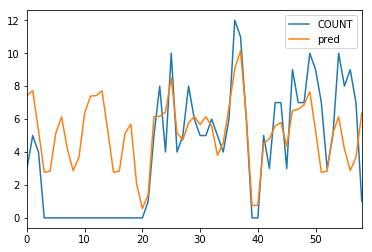

In [137]:
dat[dat.GRID_SQUARE == 44 ].reset_index()[['COUNT', 'pred']].plot()

In [127]:
crashes.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False)

GRID_SQUARE
33.0    538.0
44.0    240.0
34.0    231.0
27.0    224.0
35.0    206.0
21.0    191.0
20.0    181.0
14.0    179.0
13.0    170.0
5.0     161.0
37.0    153.0
26.0    152.0
19.0    146.0
29.0    143.0
12.0    142.0
18.0    142.0
38.0    120.0
36.0    120.0
30.0    110.0
6.0     100.0
28.0     96.0
22.0     93.0
43.0     75.0
4.0      74.0
23.0     68.0
31.0     55.0
15.0     50.0
45.0     48.0
11.0     45.0
25.0     39.0
42.0     38.0
41.0     34.0
39.0     23.0
46.0     14.0
32.0     12.0
24.0      4.0
10.0      2.0
2.0       0.0
3.0       0.0
7.0       0.0
48.0      0.0
8.0       0.0
9.0       0.0
16.0      0.0
17.0      0.0
47.0      0.0
40.0      0.0
1.0       0.0
Name: COUNT, dtype: float64